# Simulated Images for Landolt Observation

In [2]:
import os
from astroquery.simbad import Simbad
from astropy import coordinates
import astropy.units as u
import numpy as np
from matplotlib import pyplot as plt
from convenience_functions import show_image
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve, convolve_fft
from astropy.coordinates import SkyCoord
data = np.genfromtxt('satcoord.csv',delimiter=',',skip_header=1) # inputs data file from orbit and flux simulations
with fits.open("model-bias-image.fit") as hdul:  # opens mobdel bias image
    bias_data = hdul[0].data  # assume the first extension is an image



## Adjustable Parameters

In [3]:
ra_sat = data[:,1] # simulated right ascention data from landolt
dec_sat = data[:,2] # simulated declination data from landolt
sat_counts = data[:,8] # reading in simulated counts from landolt
diam_t = 0.8128 # diameter of telescope
t_eff = 0.5 # telescope efficiency
ccd_eff = 0.8 # ccd quantum efficiency
a_t = np.pi*(diam_t/2)**2 # area of the telescope aperture
ccd_size = 4096 # width of ccd in pixels
app = 0.34 # arcseconds per pixel
fov = (app*ccd_size)/60 # field of view width in arcmins
lmbda = [488e-9, 655e-9, 785e-9, 976e-9, 1064e-9, 1550e-9] # wavelength of all eight lasers
lmbda_filter = [545e-9, 641e-9, 798e-9, 1220e-9, 1220e-9, 1630e-9] # effective wavelength of the filter
zp = [363.1, 217.7, 112.6, 31.47, 31.47, 11.38] # vega zero points of all filters
bandpass = [85e-9, 150e-9, 150e-9, 260e-9, 260e-9, 290e-9] # length of wavelengths of light allowed through each filter
sccoeff = [160, 180, 200, 400, 420, 950] # sky brightness from SkyCalc
lmbda_n = 0 # { 0 - 488nm, 1 - 655nm, 2 - 785nm, 3 - 976nm, 4 - 1064nm, 5 - 1550nm }
exp_time = 90 # exposure time
tracking_mode = 1 # { 1 - sidereal rate, 2 - stationary, 3 - half sidereal rate } 

## Functions for Simulating Noise
source website is found here: https://www.astropy.org/ccd-reduction-and-photometry-guide/v/dev/notebooks/01-03-Construction-of-an-artificial-but-realistic-image.html

In [4]:
# Set up the random number generator, allowing a seed to be set from the environment
seed = os.getenv('GUIDE_RANDOM_SEED', None)

if seed is not None:
    seed = int(seed)
    
# This is the generator to use for any image component which changes in each image, e.g. read noise
# or Poisson error
noise_rng = np.random.default_rng(seed)

def read_noise(image, amount, gain=1):
    """
    Generate simulated read noise.
    
    Parameters
    ----------
    
    image: numpy array
        Image whose shape the noise array should match.
    amount : float
        Amount of read noise, in electrons.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    """
    shape = image.shape
    
    noise = noise_rng.normal(scale=amount/gain, size=shape)
    
    return noise

def dark_current(image, current, exposure_time, gain=1.0, hot_pixels=False):
    """
    Simulate dark current in a CCD, optionally including hot pixels.
    
    Parameters
    ----------
    
    image : numpy array
        Image whose shape the cosmic array should match.
    current : float
        Dark current, in electrons/pixel/second, which is the way manufacturers typically 
        report it.
    exposure_time : float
        Length of the simulated exposure, in seconds.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    strength : float, optional
        Pixel count in the cosmic rays.    
    """
    
    # dark current for every pixel; we'll modify the current for some pixels if 
    # the user wants hot pixels.
    base_current = current * exposure_time / gain
    
    # This random number generation should change on each call.
    dark_im = noise_rng.poisson(base_current, size=image.shape)
        
    if hot_pixels:
        # We'll set 0.001% of the pixels to be hot; that is probably too high but should 
        # ensure they are visible.
        y_max, x_max = dark_im.shape
        
        n_hot = int(0.00001 * x_max * y_max)
        
        # Like with the bias image, we want the hot pixels to always be in the same places
        # (at least for the same image size) but also want them to appear to be randomly
        # distributed. So we set a random number seed to ensure we always get the same thing.
        rng = np.random.RandomState(16201649)
        hot_x = rng.randint(0, x_max, size=n_hot)
        hot_y = rng.randint(0, y_max, size=n_hot)
        
        hot_current = 10000 * current
        
        dark_im[(hot_y, hot_x)] = hot_current * exposure_time / gain
    return dark_im

def sky_background(image, sky_counts, gain=1):
    """
    Generate sky background, optionally including a gradient across the image (because
    some times Moons happen).
    
    Parameters
    ----------
    
    image : numpy array
        Image whose shape the cosmic array should match.
    sky_counts : float
        The target value for the number of counts (as opposed to electrons or 
        photons) from the sky.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    """
    sky_im = noise_rng.poisson(sky_counts * gain, size=image.shape) / gain
    
    return sky_im


## Collects Flux and Positional Data of Stars from Simbad
This part of the code also filters out all stars without flux data for a given filter

In [5]:
center = SkyCoord(ra=ra_sat[0], dec=dec_sat[0], frame='icrs', unit='deg') # formats coordinates of landolt
c = coordinates.SkyCoord(center, frame='icrs') # formatted coordinates
r = (fov + 5)*u.arcminute # setting field of view
Simbad.add_votable_fields("otypes", "V", "R", "I", "J", "H") # want vmag and type of object from simbad
result_table = Simbad.query_region(c, radius=r, criteria = "otypes.otype = 'Star'") # finds stars within the field of view of the telescope around landolt
otypes = result_table.columns['otype_txt'] # records type of object

# makes sure magnitudes are taken of the correct filter
if lmbda_n == 0:
    flux = result_table.columns['V'] # records vmag
elif lmbda_n == 1:
    flux = result_table.columns['R'] # records vmag
elif lmbda_n == 2:
    flux = result_table.columns['I'] # records vmag
elif lmbda_n == 3:
    flux = result_table.columns['J'] # records vmag
elif lmbda_n == 4:
    flux = result_table.columns['J'] # records vmag
elif lmbda_n == 5:
    flux = result_table.columns['H'] # records vmag
    
# retrieves vmag of all stars that have vmag measurements and excludes those that don't
index = []
for i in range(len(flux)):
    if flux[i] > 0:
        index.append(i)
    else:
        pass

KeyError: 'V: no such field'

## Defines Range of RA and Dec Values in the Field of View

In [6]:
ra = result_table.columns['ra'][index] # pulling ra data of stars around landolt
if tracking_mode == 1:
    ra = ra[np.where(ra > ra_sat[0])] # setting landolt to appear to the far left side of the image
    ra = ra[np.where(abs(ra_sat[0] - ra) < fov/60)]
    ra_range = np.linspace(ra_sat[0],ra_sat[0] + fov/60,num=ccd_size) # assigns each pixel an ra value
else:
    ra = ra[np.where(abs(ra - ra_sat[0]) < fov/120)]
    ra_range = np.linspace(min(ra),max(ra),num=ccd_size) # assigns each pixel an ra value
dec = result_table.columns['dec'][index] # same for declination
dec = dec[np.where(abs(dec - dec_sat[0]) < fov/120)]

NameError: name 'result_table' is not defined

## Calculates Counts from Stars in the Field of View as well as Sky Noise

In [12]:
flux = flux[index] # retrieves vmags of all stars
flux = exp_time*(10**(flux/(-2.5)))*(zp[lmbda_n]*1e-7*10000*a_t*1e10*bandpass[lmbda_n]*1e-11) # converts magnitude to flux
counts = (flux*lmbda[lmbda_n])/(6.62607015e-34*299792458) # converts flux to counts
# factor influencing sky noise comes from https://cires.colorado.edu/Artificial-light (multiply ratio at bottom of page to normal sky brightness)
sky_counts = exp_time*(sccoeff[lmbda_n]*(np.pi*(diam_t/2)**2)*bandpass[lmbda_n]*1e6*(app**2))*t_eff # https://www.eso.org/observing/etc/bin/gen/form?INS.MODE=swspectr+INS.NAME=SKYCALC - counts from sky background

## Creates PSF and Prepares for Image Simulation

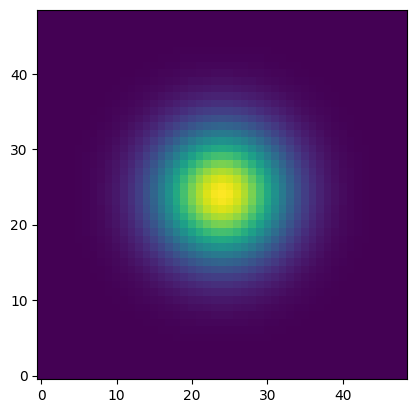

In [13]:
ra_step = abs(ra_range[1]-ra_range[0]) # the difference in ra between two pixels
dec_range = np.linspace(min(dec),max(dec),num=ccd_size) # assigns each pixel a dec value
dec_step = abs(dec_range[1]-dec_range[0]) # the difference in dec between two pixels

synthetic_image = np.zeros([ccd_size,ccd_size]) # creates simulated image base
gaussian_2D_kernel = Gaussian2DKernel(6) # creates PSF
plt.imshow(gaussian_2D_kernel, interpolation='none', origin='lower') # shows PSF

# Tracking Mode One

In [14]:
# for sidereal rate
if tracking_mode == 1: 
    
    # adds stars around landolt to simulated image base
    for i in range(len(ra)):
        close = np.where(abs(ra[i] - ra_range) <= ra_step)
        close2 = np.where(abs(dec[i] - dec_range) <= dec_step)
        rweight_1, rweight_2 = (abs(ra[i] - ra_range[close]) / ra_step) / 4
        dweight_1, dweight_2 = (abs(dec[i] - dec_range[close2]) / dec_step) / 4
        weight00 = rweight_1 + dweight_1
        weight10 = rweight_1 + dweight_2
        weight11 = rweight_2 + dweight_2
        weight01 = rweight_2 + dweight_1
        synthetic_image[close2[0][0],close[0][0]] = synthetic_image[close2[0][0],close[0][0]] + weight00*counts[i]*t_eff*ccd_eff
        synthetic_image[close2[0][0],close[0][1]] = synthetic_image[close2[0][0],close[0][1]] + weight01*counts[i]*t_eff*ccd_eff
        synthetic_image[close2[0][1],close[0][1]] = synthetic_image[close2[0][1],close[0][1]] + weight11*counts[i]*t_eff*ccd_eff
        synthetic_image[close2[0][1],close[0][0]] = synthetic_image[close2[0][1],close[0][0]] + weight10*counts[i]*t_eff*ccd_eff
    
    # adds landolt to simulated image base
    for i in range(exp_time-1):
        streakra = np.linspace(ra_sat[i], ra_sat[i+1], num = 50)
        streakdec = np.linspace(dec_sat[i], dec_sat[i+1], num = 50)
        for j in range(len(streakra)):
            close = np.where(abs(streakra[j] - ra_range) <= ra_step)
            close2 = np.where(abs(streakdec[j] - dec_range) <= dec_step)
            rweight_1, rweight_2 = (abs(streakra[j] - ra_range[close]) / ra_step) / (50*4)
            dweight_1, dweight_2 = (abs(streakdec[j] - dec_range[close2]) / dec_step) / (50*4)
            weight00 = rweight_1 + dweight_1
            weight10 = rweight_1 + dweight_2
            weight11 = rweight_2 + dweight_2
            weight01 = rweight_2 + dweight_1
            synthetic_image[close2[0][0],close[0][0]] = synthetic_image[close2[0][0],close[0][0]] + weight00*sat_counts[i]*t_eff*ccd_eff
            synthetic_image[close2[0][0],close[0][1]] = synthetic_image[close2[0][0],close[0][1]] + weight01*sat_counts[i]*t_eff*ccd_eff
            synthetic_image[close2[0][1],close[0][1]] = synthetic_image[close2[0][1],close[0][1]] + weight11*sat_counts[i]*t_eff*ccd_eff
            synthetic_image[close2[0][1],close[0][0]] = synthetic_image[close2[0][1],close[0][0]] + weight10*sat_counts[i]*t_eff*ccd_eff
    
    """
    test_synthetic_image = np.zeros([ccd_size,ccd_size]) # creates test simulated image base
    # adds landolt to simulated image base
    while max(test_synthetic_image.flatten()) < 65000:
        print(exp_time)
        print(max(test_synthetic_image.flatten()))
        test_synthetic_image = np.zeros([ccd_size,ccd_size]) # creates test simulated image base
        close = np.where(abs(ra_sat[0] - ra_range) <= ra_step)
        close2 = np.where(abs(dec_sat[0] - dec_range) <= dec_step)
        rweight_1, rweight_2 = (abs(ra_sat[0] - ra_range[close]) / ra_step) / 4
        dweight_1, dweight_2 = (abs(dec_sat[0] - dec_range[close2]) / dec_step) / 4
        weight00 = rweight_1 + dweight_2
        weight01 = rweight_1 + dweight_1
        weight11 = rweight_2 + dweight_1
        weight10 = rweight_2 + dweight_2
        test_synthetic_image[close[0][0],close2[0][0]] = test_synthetic_image[close[0][0],close2[0][0]] + weight00*sat_counts[0]*t_eff*ccd_eff*exp_time
        test_synthetic_image[close[0][0],close2[0][1]] = test_synthetic_image[close[0][0],close2[0][1]] + weight01*sat_counts[0]*t_eff*ccd_eff*exp_time
        test_synthetic_image[close[0][1],close2[0][1]] = test_synthetic_image[close[0][1],close2[0][1]] + weight11*sat_counts[0]*t_eff*ccd_eff*exp_time
        test_synthetic_image[close[0][1],close2[0][0]] = test_synthetic_image[close[0][1],close2[0][0]] + weight10*sat_counts[0]*t_eff*ccd_eff*exp_time
        test_synthetic_image = convolve_fft(test_synthetic_image, gaussian_2D_kernel) # convolves stars with PSF
        test_synthetic_image = test_synthetic_image + read_noise(test_synthetic_image, 5) + bias_data + dark_current(test_synthetic_image, 0.1, exp_time) + sky_background(test_synthetic_image, (sky_v_counts)*ccd_eff) # adds noise
        exp_time = exp_time + 1
    """

# Tracking Mode Two

In [ ]:
# for stationary telescope
if tracking_mode == 2:
    
    # adds stars around landolt to simulated image base
    for s in range(len(ra)):  
        for i in range(exp_time):
            streakra = np.linspace(ra[s], ra[s] + 0.00417807462379, num = 50)
            for j in range(len(streakra)):
                close = np.where(abs(streakra[j] - ra_range) <= ra_step)
                if np.size(close) == 1:
                    break
                elif np.size(close) == 0:
                    break
                else:
                    close2 = np.where(abs(dec[s] - dec_range) <= dec_step)
                    rweight_1, rweight_2 = (abs(streakra[j] - ra_range[close]) / ra_step) / (50*4)
                    dweight_1, dweight_2 = (abs(dec[s] - dec_range[close2]) / dec_step) / (50*4)
                    weight00 = rweight_1 + dweight_1
                    weight10 = rweight_1 + dweight_2
                    weight11 = rweight_2 + dweight_2
                    weight01 = rweight_2 + dweight_1
                    synthetic_image[close2[0][0],close[0][0]] = synthetic_image[close2[0][0],close[0][0]] + weight00*counts[s]*t_eff*ccd_eff
                    synthetic_image[close2[0][0],close[0][1]] = synthetic_image[close2[0][0],close[0][1]] + weight01*counts[s]*t_eff*ccd_eff
                    synthetic_image[close2[0][1],close[0][1]] = synthetic_image[close2[0][1],close[0][1]] + weight11*counts[s]*t_eff*ccd_eff
                    synthetic_image[close2[0][1],close[0][0]] = synthetic_image[close2[0][1],close[0][0]] + weight10*counts[s]*t_eff*ccd_eff
            ra[s] = ra[s] + 0.00417807462379
    
    # adds landolt to simulated image base
    for i in range(exp_time-1):
        ra_sat[i+1] = ra_sat[i+1] - 0.00417807462379*(1+i)
        streakra = np.linspace(ra_sat[i], ra_sat[i+1], num = 50)
        streakdec = np.linspace(dec_sat[i], dec_sat[i+1], num = 50)
        for j in range(len(streakra)):
            close = np.where(abs(streakra[j] - ra_range) <= ra_step)
            close2 = np.where(abs(streakdec[j] - dec_range) <= dec_step)
            rweight_1, rweight_2 = (abs(streakra[j] - ra_range[close]) / ra_step) / (50*4)
            dweight_1, dweight_2 = (abs(streakdec[j] - dec_range[close2]) / dec_step) / (50*4)
            weight00 = rweight_1 + dweight_1
            weight10 = rweight_1 + dweight_2
            weight11 = rweight_2 + dweight_2
            weight01 = rweight_2 + dweight_1
            synthetic_image[close2[0][0],close[0][0]] = synthetic_image[close2[0][0],close[0][0]] + weight00*sat_counts[i]*t_eff*ccd_eff
            synthetic_image[close2[0][0],close[0][1]] = synthetic_image[close2[0][0],close[0][1]] + weight01*sat_counts[i]*t_eff*ccd_eff
            synthetic_image[close2[0][1],close[0][1]] = synthetic_image[close2[0][1],close[0][1]] + weight11*sat_counts[i]*t_eff*ccd_eff
            synthetic_image[close2[0][1],close[0][0]] = synthetic_image[close2[0][1],close[0][0]] + weight10*sat_counts[i]*t_eff*ccd_eff
    
    """
    test_synthetic_image = np.zeros([ccd_size,ccd_size]) # creates test simulated image base
    # adds landolt to simulated image base
    while max(test_synthetic_image.flatten()) < 65000:
        print(exp_time)
        print(max(test_synthetic_image.flatten()))
        test_synthetic_image = np.zeros([ccd_size,ccd_size]) # creates test simulated image base
        close = np.where(abs(ra_sat[0] - ra_range) <= ra_step)
        close2 = np.where(abs(dec_sat[0] - dec_range) <= dec_step)
        rweight_1, rweight_2 = (abs(ra_sat[0] - ra_range[close]) / ra_step) / 4
        dweight_1, dweight_2 = (abs(dec_sat[0] - dec_range[close2]) / dec_step) / 4
        weight00 = rweight_1 + dweight_2
        weight01 = rweight_1 + dweight_1
        weight11 = rweight_2 + dweight_1
        weight10 = rweight_2 + dweight_2
        test_synthetic_image[close[0][0],close2[0][0]] = test_synthetic_image[close[0][0],close2[0][0]] + weight00*sat_counts[0]*t_eff*ccd_eff*exp_time
        test_synthetic_image[close[0][0],close2[0][1]] = test_synthetic_image[close[0][0],close2[0][1]] + weight01*sat_counts[0]*t_eff*ccd_eff*exp_time
        test_synthetic_image[close[0][1],close2[0][1]] = test_synthetic_image[close[0][1],close2[0][1]] + weight11*sat_counts[0]*t_eff*ccd_eff*exp_time
        test_synthetic_image[close[0][1],close2[0][0]] = test_synthetic_image[close[0][1],close2[0][0]] + weight10*sat_counts[0]*t_eff*ccd_eff*exp_time
        test_synthetic_image = convolve_fft(test_synthetic_image, gaussian_2D_kernel) # convolves stars with PSF
        test_synthetic_image = test_synthetic_image + read_noise(test_synthetic_image, 5) + bias_data + dark_current(test_synthetic_image, 0.1, exp_time) + sky_background(test_synthetic_image, (sky_v_counts)*ccd_eff) # adds noise
        exp_time = exp_time + 1
    """

# Tracking Mode Three

In [ ]:
# for half sidereal rate
if tracking_mode == 3:
    
    # adds stars around landolt to simulated image base
    for s in range(len(ra)):  
        for i in range(exp_time):
            streakra = np.linspace(ra[s], ra[s] + 0.0020890373119, num = 50)
            for j in range(len(streakra)):
                close = np.where(abs(streakra[j] - ra_range) <= ra_step)
                if np.size(close) == 1:
                    break
                elif np.size(close) == 0:
                    break
                else:
                    close2 = np.where(abs(dec[s] - dec_range) <= dec_step)
                    rweight_1, rweight_2 = (abs(streakra[j] - ra_range[close]) / ra_step) / (50*4)
                    dweight_1, dweight_2 = (abs(dec[s] - dec_range[close2]) / dec_step) / (50*4)
                    weight00 = rweight_1 + dweight_1
                    weight10 = rweight_1 + dweight_2
                    weight11 = rweight_2 + dweight_2
                    weight01 = rweight_2 + dweight_1
                    synthetic_image[close2[0][0],close[0][0]] = synthetic_image[close2[0][0],close[0][0]] + weight00*counts[s]*t_eff*ccd_eff
                    synthetic_image[close2[0][0],close[0][1]] = synthetic_image[close2[0][0],close[0][1]] + weight01*counts[s]*t_eff*ccd_eff
                    synthetic_image[close2[0][1],close[0][1]] = synthetic_image[close2[0][1],close[0][1]] + weight11*counts[s]*t_eff*ccd_eff
                    synthetic_image[close2[0][1],close[0][0]] = synthetic_image[close2[0][1],close[0][0]] + weight10*counts[s]*t_eff*ccd_eff
            ra[s] = ra[s] + 0.0020890373119
    
    # adds landolt to simulated image base
    for i in range(exp_time-1):
        ra_sat[i+1] = ra_sat[i+1] - 0.0020890373119*(1+i)
        streakra = np.linspace(ra_sat[i], ra_sat[i+1], num = 50)
        streakdec = np.linspace(dec_sat[i], dec_sat[i+1], num = 50)
        for j in range(len(streakra)):
            close = np.where(abs(streakra[j] - ra_range) <= ra_step)
            close2 = np.where(abs(streakdec[j] - dec_range) <= dec_step)
            rweight_1, rweight_2 = (abs(streakra[j] - ra_range[close]) / ra_step) / (50*4)
            dweight_1, dweight_2 = (abs(streakdec[j] - dec_range[close2]) / dec_step) / (50*4)
            weight00 = rweight_1 + dweight_1
            weight10 = rweight_1 + dweight_2
            weight11 = rweight_2 + dweight_2
            weight01 = rweight_2 + dweight_1
            synthetic_image[close2[0][0],close[0][0]] = synthetic_image[close2[0][0],close[0][0]] + weight00*sat_counts[i]*t_eff*ccd_eff
            synthetic_image[close2[0][0],close[0][1]] = synthetic_image[close2[0][0],close[0][1]] + weight01*sat_counts[i]*t_eff*ccd_eff
            synthetic_image[close2[0][1],close[0][1]] = synthetic_image[close2[0][1],close[0][1]] + weight11*sat_counts[i]*t_eff*ccd_eff
            synthetic_image[close2[0][1],close[0][0]] = synthetic_image[close2[0][1],close[0][0]] + weight10*sat_counts[i]*t_eff*ccd_eff


# Creates, Shows, and Exports Simulated Image

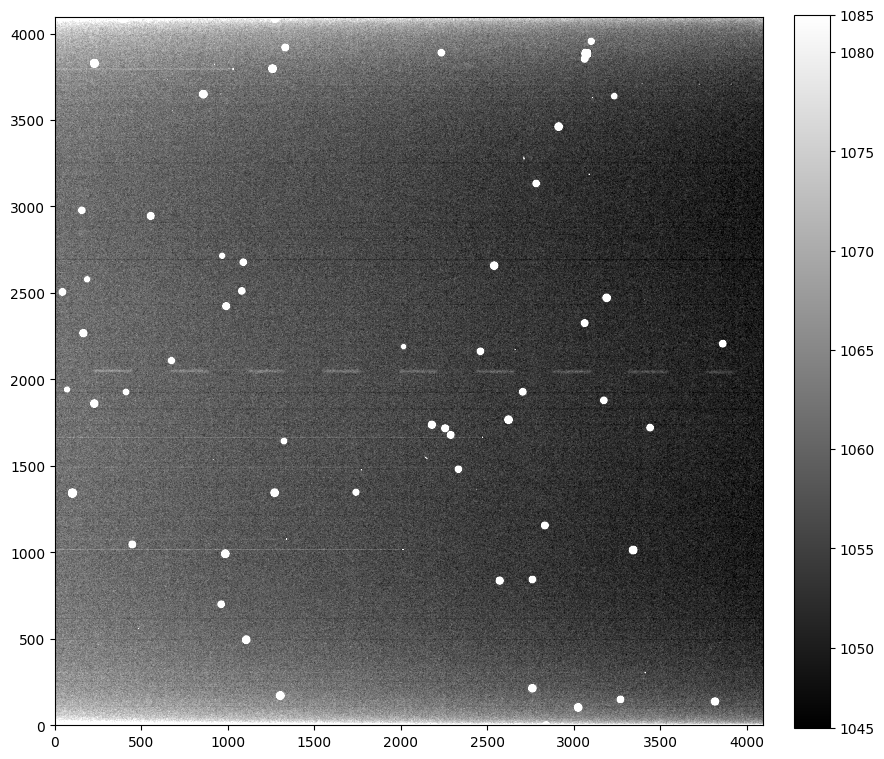

In [15]:
synthetic_image = convolve(synthetic_image, gaussian_2D_kernel) # convolves stars with PSF
synthetic_image = synthetic_image + read_noise(synthetic_image, 5) + bias_data + dark_current(synthetic_image, 0.1, exp_time) + sky_background(synthetic_image, (sky_counts)*ccd_eff) # adds noise
    
show_image(synthetic_image, cmap='gray', percl=99) # displays image       

# outputs data
hdu = fits.PrimaryHDU(data=synthetic_image)
hdul = fits.HDUList([hdu])
hdul.writeto('mode1extracounts.fits', overwrite=True)